In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['DDE_BACKEND'] = 'tensorflow'

In [2]:
import deepxde as dde 
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt

2023-10-08 13:39:46.744840: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-08 13:39:46.744902: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-08 13:39:46.744952: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-08 13:39:46.754151: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends

Enable just-in-time compilation with XLA.



## PINN with small data

### Define Parameters

In [3]:
E = 50
nu = 0.3
a = 10
b = 10
f = 1
h = 1

### Define PDE with Boundary Conditions

In [4]:
def pde(X, Y):
    du_xx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
    du_xy = dde.grad.hessian(Y, X, component=0, i=0, j=1)

    dv_xx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(Y, X, component=1, i=1, j=1)
    dv_xy = dde.grad.hessian(Y, X, component=1, i=0, j=1)

    force_eq_x = (du_xx + 0.5*(1-nu)*du_yy + 0.5*(1+nu)*dv_xy)*E/(1-nu**2)
    force_eq_y = (dv_yy + 0.5*(1-nu)*dv_xx + 0.5*(1+nu)*du_xy)*E/(1-nu**2)

    return [force_eq_x, force_eq_y]

In [5]:
def boundary_x(X, on_boundary):
    return on_boundary and np.isclose(X[0], a)

def boundary_y(X, on_boundary):
    return on_boundary and np.isclose(X[1], b)

def boundary_x0(X, on_boundary):
    return on_boundary and np.isclose(X[0], 0)

def boundary_y0(X, on_boundary):
    return on_boundary and np.isclose(X[1], 0)

def BC_xy(X, Y):
    du_x = dde.grad.jacobian(Y, X, i=0, j=0)
    du_y = dde.grad.jacobian(Y, X, i=0, j=1)
    dv_x = dde.grad.jacobian(Y, X, i=1, j=0)
    dv_y = dde.grad.jacobian(Y, X, i=1, j=1)

    sig_xx = (du_x + nu*dv_y)*E/(1-nu**2)
    sig_yy = (dv_y + nu*du_x)*E/(1-nu**2)
    sig_xy = (dv_x + du_y)*E/(1+nu)/2

    sig_ex = f * h * tf.reshape(tf.math.cos(np.pi / (2 * b) * X[:, 1]), [-1, 1])

    return sig_xx-sig_ex, sig_xy, sig_yy

### Load and Sample Data

In [6]:
Plate_data = np.load('../Plate_data.npy')

loc = Plate_data[:, 0:2]
u = Plate_data[:, 2:3]
v = Plate_data[:, 3:4]
stress = Plate_data[:, 4:6]

In [7]:
tr_sample = np.array([np.where(loc[:,0] == i) for i in [2, 5, 8]]).reshape(-1,)
x_sample = loc[tr_sample, :]
u_sample = u[tr_sample, :]
v_sample = v[tr_sample, :]

In [8]:
observe_u = dde.icbc.PointSetBC(x_sample, u_sample, component=0)
observe_v = dde.icbc.PointSetBC(x_sample, v_sample, component=1)

2023-10-08 13:40:58.386799: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-10-08 13:40:58.387696: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10520 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:82:00.0, compute capability: 7.0


### Define Geometry and Implement Boundary Conditions

In [9]:
geom = dde.geometry.Rectangle(xmin=[0, 0], xmax=[a, b])

bc_Y0 = dde.DirichletBC(geom, lambda x: 0, boundary_y0, component=1)
bc_X0 = dde.DirichletBC(geom, lambda x: 0, boundary_x0, component=0)

bc_free_yy = dde.OperatorBC(geom, lambda X, Y, _: BC_xy(X, Y)[2], boundary_y)
bc_free_yx = dde.OperatorBC(geom, lambda X, Y, _: BC_xy(X, Y)[1], boundary_y)

bc_traction = dde.OperatorBC(geom, lambda X, Y, _: BC_xy(X, Y)[0], boundary_x)
bc_free_xy = dde.OperatorBC(geom, lambda X, Y, _: BC_xy(X, Y)[1], boundary_x)

In [12]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_Y0, bc_X0, bc_free_yy, bc_free_yx, bc_traction, bc_free_xy, observe_u, observe_v],
                    num_domain=100,
                    num_boundary=100,
                    num_test=100,
                    train_distribution='LHS')

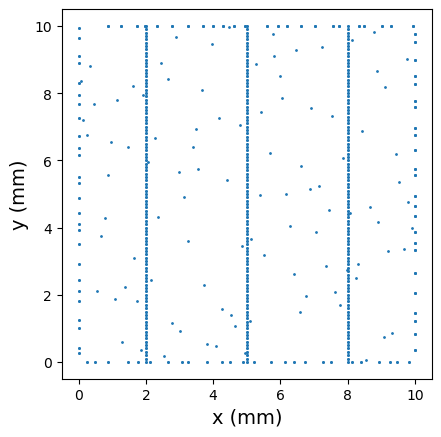

In [13]:
plt.scatter(data.train_x[:, 0], data.train_x[:, 1], s=1)
plt.xlabel('x (mm)', fontsize=14)
plt.ylabel('y (mm)', fontsize=14)
plt.axis('square')
plt.xlim([-0.5, a+0.5])
plt.show()

In [14]:
layer_size = [2] + [64] * 5 + [2]
activation = 'tanh'
initializer = 'Glorot uniform'

net = dde.maps.FNN(layer_size, activation, initializer)

In [15]:
model = dde.Model(data, net)

In [16]:
# loss weights
# [force_eq_x, force_eq_y]
# [bc_Y0, bc_X0, bc_free_yy, bc_free_yx, bc_traction, bc_free_xy, observe_u, observe_v]
model.compile('adam', lr=1e-3, loss_weights=[1, 1, 1, 1, 1, 1, 1, 1, 9, 9])

Compiling model...
'compile' took 0.017574 s



### Train (Adam Optimizer)

Training model...



/userhome/jeon_mg/miniforge3/envs/pinn_tf/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Cause: could not parse the source code of <function <lambda> at 0x7f7fc5495630>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f7fc5495630>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f7fc5495990>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f7fc5495990>: no matc

2023-10-08 13:45:37.463159: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5622d5e95260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-08 13:45:37.463196: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN V, Compute Capability 7.0
2023-10-08 13:45:37.502781: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-08 13:45:38.259087: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-08 13:45:38.277019: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-08 13:45:39.070780: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                                                                                              Test loss                                                                                               Test metric
0         [1.28e+00, 2.65e+00, 2.96e-01, 3.63e-01, 2.36e-01, 8.86e-01, 7.56e-01, 2.39e-01, 3.14e+00, 5.09e+00]    [1.66e+00, 1.88e+00, 2.96e-01, 3.63e-01, 2.36e-01, 8.86e-01, 7.56e-01, 2.39e-01, 3.14e+00, 5.09e+00]    []  
1000      [4.62e-04, 5.77e-04, 1.09e-04, 1.13e-05, 7.99e-05, 4.71e-05, 1.68e-04, 1.30e-04, 1.69e-04, 1.10e-04]    [3.59e-04, 7.67e-04, 1.09e-04, 1.13e-05, 7.99e-05, 4.71e-05, 1.68e-04, 1.30e-04, 1.69e-04, 1.10e-04]    []  
2000      [2.48e-04, 3.64e-04, 4.92e-05, 5.98e-06, 5.73e-05, 3.07e-05, 9.71e-05, 7.98e-05, 8.23e-05, 3.96e-05]    [1.89e-04, 4.32e-04, 4.92e-05, 5.98e-06, 5.73e-05, 3.07e-05, 9.71e-05, 7.98e-05, 8.23e-05, 3.96e-05]    []  
3000      [1.13e-04, 2.32e-04, 1.90e-05, 3.69e-06, 2.91e-05, 1.63e-05, 3.72e-05, 3.68e-05, 3.44e-05, 

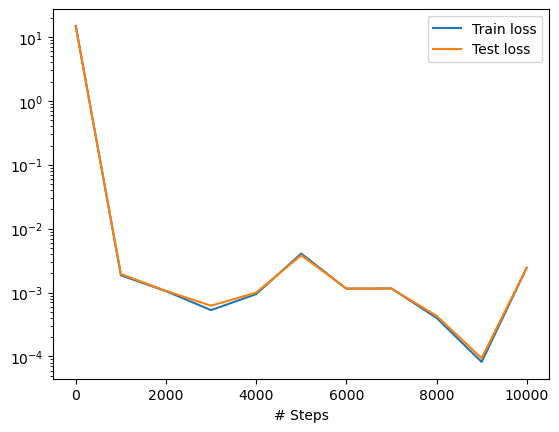

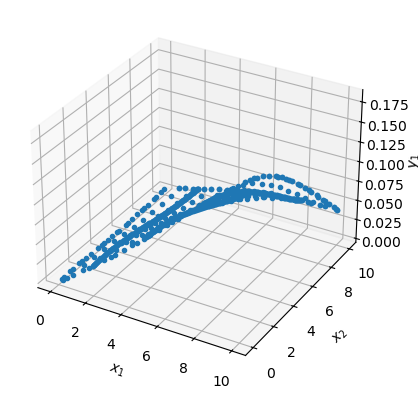

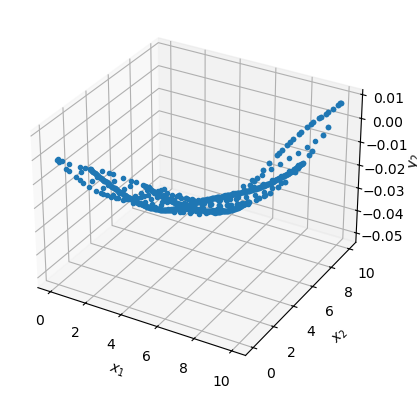

In [17]:
loss_history, train_state = model.train(iterations=10000)

dde.saveplot(loss_history, train_state, issave=False, isplot=True)

### Plot Results (Adam Optimizer)

In [18]:
def check_stress(net, X):
    X = tf.constant(X)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(X)
        disp = net(X)
        u_pred = tf.reshape(disp[:, 0], [-1, 1])
        v_pred = tf.reshape(disp[:, 1], [-1, 1])
    
    du_X = tape.gradient(u_pred, X)
    dv_X = tape.gradient(v_pred, X)

    du_x, du_y = du_X[:, 0], du_X[:, 1]
    dv_x, dv_y = dv_X[:, 0], dv_X[:, 1]

    sig_xx = tf.reshape( (du_x + nu*dv_y)*E/(1-nu**2), [-1, 1] )
    sig_yy = tf.reshape( (dv_y + nu*du_x)*E/(1-nu**2), [-1, 1] )
    
    return sig_xx, sig_yy

In [19]:
color_legend = [[0, 0.182], [-0.06, 0.011], [-0.0022, 1.0], [-0.15, 0.45]]
title = ['x-displacement ($u$)', 'y-displacement ($v$)', '$\sigma_{xx}$', '$\sigma_{yy}$']

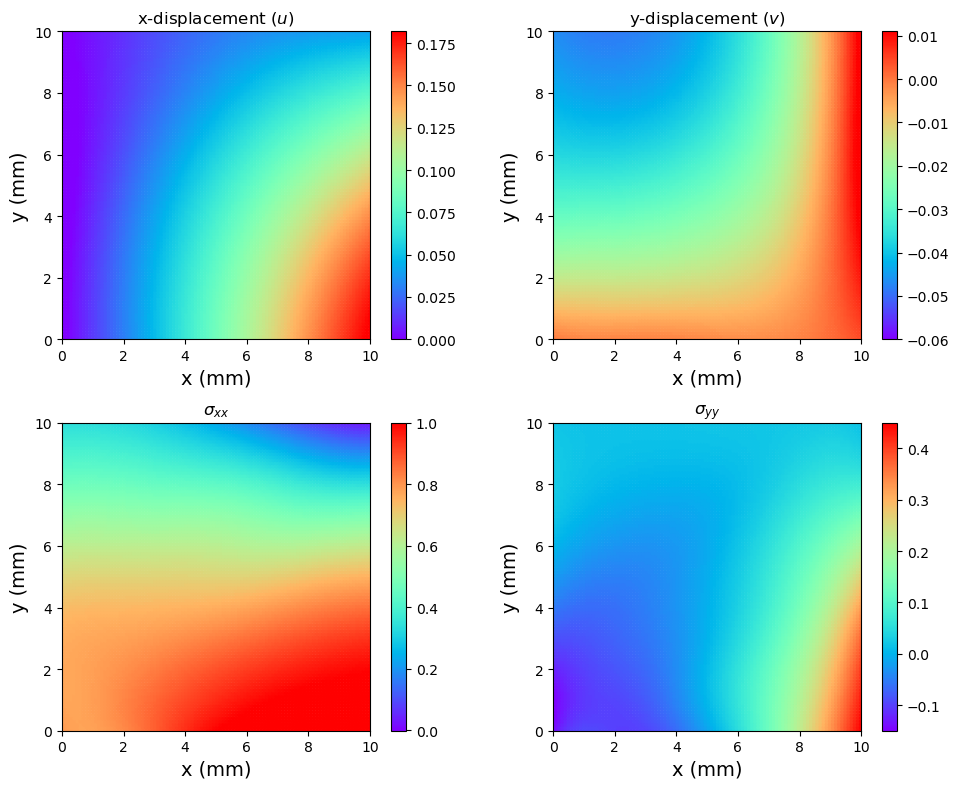

In [20]:
samples = geom.uniform_points(10000)
small_disp = model.predict(samples)
small_sg = np.hstack(check_stress(model.net, samples))
small_result = np.hstack([small_disp, small_sg])

plt.figure(figsize=(10, 8))
for idx in range(4):
    plt.subplot(2, 2, idx+1)
    plt.scatter(samples[:, 0], samples[:, 1], c=small_result[:, idx], cmap='rainbow', s=5)
    plt.clim(color_legend[idx])
    plt.title(title[idx])
    plt.xlabel('x (mm)', fontsize = 14)
    plt.ylabel('y (mm)', fontsize = 14)
    plt.axis('square')
    plt.xlim([0, a])
    plt.ylim([0, b])
    plt.colorbar()
plt.tight_layout()
plt.show()

### Train More (L-BFGS Optimizer)

Compiling model...
'compile' took 0.009984 s

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
10000     [8.69e-05, 4.76e-05, 2.71e-06, 2.04e-05, 3.58e-04, 5.88e-06, 1.68e-03, 1.05e-05, 1.71e-05, 8.12e-06]    [9.98e-05, 4.32e-05, 2.71e-06, 2.04e-05, 3.58e-04, 5.88e-06, 1.68e-03, 1.05e-05, 1.71e-05, 8.12e-06]    []  


2023-10-08 13:49:10.466423: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'fusion_75', 208 bytes spill stores, 220 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'fusion_77', 224 bytes spill stores, 216 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'fusion_78', 224 bytes spill stores, 216 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'fusion_79', 80 bytes spill stores, 76 bytes spill loads



11727     [2.34e-06, 1.67e-06, 6.95e-08, 5.18e-08, 3.74e-07, 1.18e-07, 2.10e-07, 6.52e-08, 1.39e-07, 8.62e-08]    [6.47e-06, 3.47e-06, 6.95e-08, 5.18e-08, 3.74e-07, 1.18e-07, 2.10e-07, 6.52e-08, 1.39e-07, 8.62e-08]    []  

Best model at step 11727:
  train loss: 5.12e-06
  test loss: 1.10e-05
  test metric: []

'train' took 598.795391 s



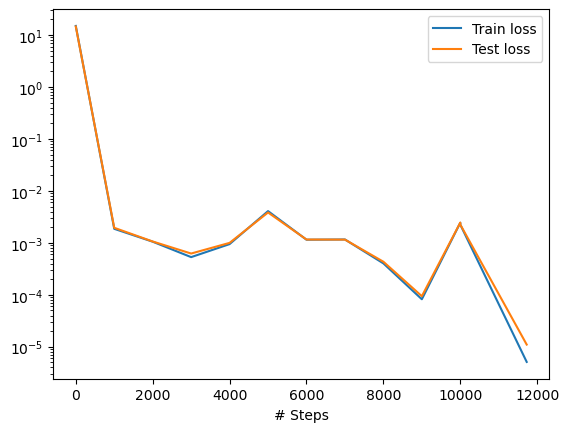

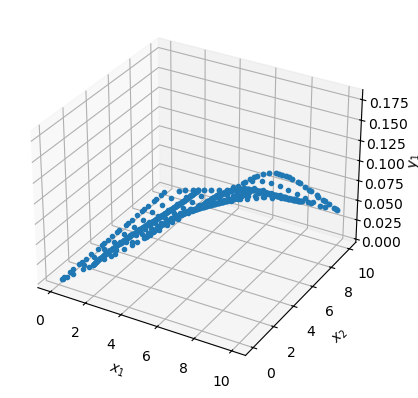

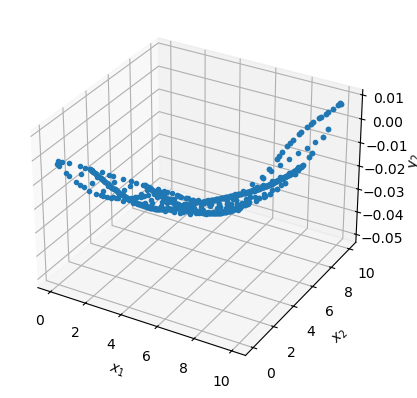

In [21]:
dde.optimizers.config.set_LBFGS_options(maxiter=3000)
model.compile('L-BFGS')
loss_history, train_state = model.train()
dde.saveplot(loss_history, train_state, issave=False, isplot=True)

### Plot Results (Adam + L-BFGS)

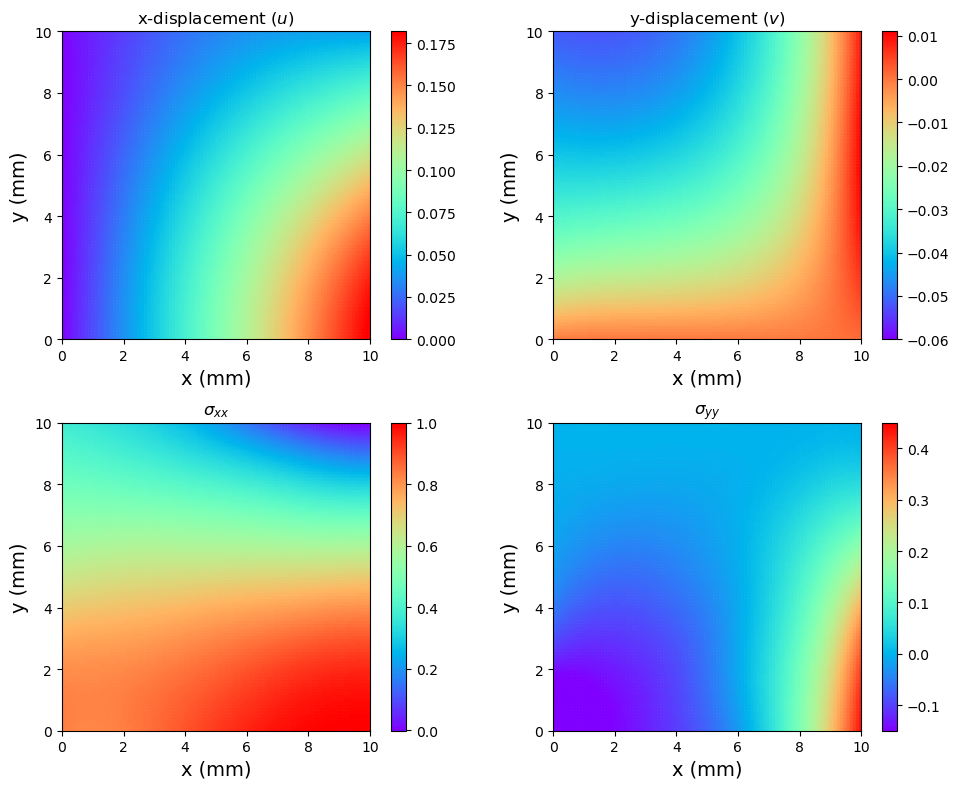

In [23]:
samples = geom.uniform_points(10000)
pde_small_disp = model.predict(samples)
pde_small_sg = np.hstack(check_stress(model.net, samples))
pde_small_result = np.hstack([pde_small_disp, pde_small_sg])

plt.figure(figsize=(10, 8))
for idx in range(4):
    plt.subplot(2, 2, idx+1)
    plt.scatter(samples[:, 0], samples[:, 1], c=pde_small_result[:, idx], cmap='rainbow', s=5)
    plt.clim(color_legend[idx])
    plt.title(title[idx])
    plt.xlabel('x (mm)', fontsize = 14)
    plt.ylabel('y (mm)', fontsize = 14)
    plt.axis('square')
    plt.xlim([0, a])
    plt.ylim([0, b])
    plt.colorbar()
plt.tight_layout()
plt.show()

### Save and Restore

In [24]:
model.predict(samples)

array([[ 1.1930801e-04, -6.5191602e-04],
       [ 9.6347183e-05, -1.6016727e-03],
       [ 7.4544922e-05, -2.5479512e-03],
       ...,
       [ 4.4218950e-02,  8.4031280e-03],
       [ 4.2292036e-02,  8.3862599e-03],
       [ 4.0369540e-02,  8.3788186e-03]], dtype=float32)

In [25]:
model.save('model/pde_small', verbose=1)

Epoch 11727: saving model to model/pde_small-11727.ckpt ...



'model/pde_small-11727.ckpt'

In [26]:
mm = dde.Model(data, net)

In [27]:
mm.restore('model/pde_small-11727.ckpt')

In [28]:
mm.compile('adam', lr=1e-3)

Compiling model...
'compile' took 0.005515 s



In [29]:
mm.predict(samples)

array([[ 1.1930801e-04, -6.5191602e-04],
       [ 9.6347183e-05, -1.6016727e-03],
       [ 7.4544922e-05, -2.5479512e-03],
       ...,
       [ 4.4218950e-02,  8.4031280e-03],
       [ 4.2292036e-02,  8.3862599e-03],
       [ 4.0369540e-02,  8.3788186e-03]], dtype=float32)

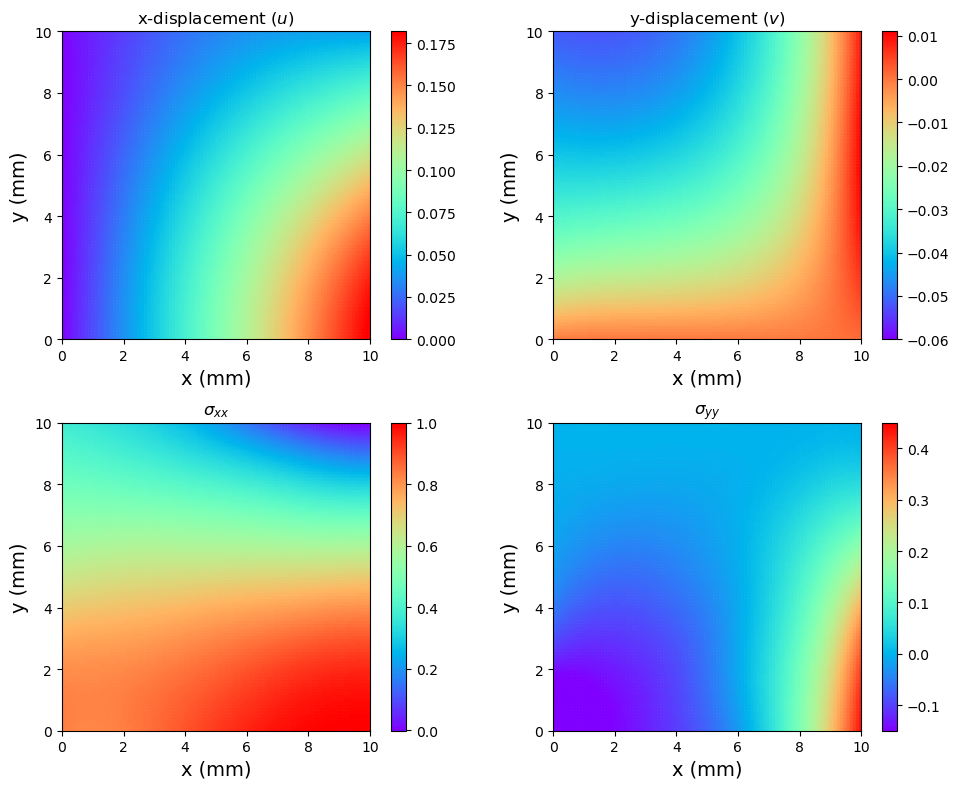

In [30]:
samples = geom.uniform_points(10000)
pde_small_disp = mm.predict(samples)
pde_small_sg = np.hstack(check_stress(mm.net, samples))
pde_small_result = np.hstack([pde_small_disp, pde_small_sg])

plt.figure(figsize=(10, 8))
for idx in range(4):
    plt.subplot(2, 2, idx+1)
    plt.scatter(samples[:, 0], samples[:, 1], c=pde_small_result[:, idx], cmap='rainbow', s=5)
    plt.clim(color_legend[idx])
    plt.title(title[idx])
    plt.xlabel('x (mm)', fontsize = 14)
    plt.ylabel('y (mm)', fontsize = 14)
    plt.axis('square')
    plt.xlim([0, a])
    plt.ylim([0, b])
    plt.colorbar()
plt.tight_layout()
plt.show()